Beginning of a skeleton NN notebook: try to match the architecture provided in the papers.

In [1]:
# Import libraries
import matplotlib 
from matplotlib import pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Set larger fontsize for all plots
%load_ext autoreload
%autoreload 2

Using TensorFlow backend.


Setting up the data will be simple:

In [12]:
# Load the data
df = pd.read_csv('mol_res_scan_results_1.csv')
df.head()

,Unnamed: 0,cut 1,cut 2,yield,purity,c_s,v,mol1_D_L,mol1_k_ov,mol1_q_max,...,mol1_z_p,mol1_n,mol1_K_s,mol2_D_L,mol2_k_ov,mol2_q_max,mol2_K_eq,mol2_z_p,mol2_n,mol2_K_s
0,0,0.0,3.0,0.000212,0.049710,0.2,0.478557,0.059,5.42,0.041294,...,2.367878,0,0,0.059,5.42,0.016222,487.821861,3.979901,0,0
1,1,0.0,6.0,0.023141,0.134193,0.2,0.478557,0.059,5.42,0.041294,...,2.367878,0,0,0.059,5.42,0.016222,487.821861,3.979901,0,0
2,2,0.0,9.0,0.247191,0.551462,0.2,0.478557,0.059,5.42,0.041294,...,2.367878,0,0,0.059,5.42,0.016222,487.821861,3.979901,0,0
3,3,0.0,12.0,0.435082,0.670937,0.2,0.478557,0.059,5.42,0.041294,...,2.367878,0,0,0.059,5.42,0.016222,487.821861,3.979901,0,0
4,4,0.0,15.0,0.548752,0.713056,0.2,0.478557,0.059,5.42,0.041294,...,2.367878,0,0,0.059,5.42,0.016222,487.821861,3.979901,0,0


In [13]:
seed = 42 

# do we need to get rid of cut 1/ cut 2? what are the important features here?

X = df[['cut 1','cut 2','c_s','v','mol1_D_L','mol1_k_ov','mol1_q_max','mol1_K_eq','mol1_z_p','mol1_n','mol1_K_s','mol2_D_L','mol2_k_ov','mol2_q_max','mol2_K_eq','mol2_z_p','mol2_n','mol2_K_s']].values
Y = df[['yield','purity']].values

# Split into testing and training
X_train_pn, X_test_pn, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=seed)

In [14]:
# is scaling the data important?

X_train_scaler = StandardScaler().fit(X_train_pn)

X_train = X_train_scaler.transform(X_train_pn)

X_test = X_train_scaler.transform(X_test_pn)

The following needs to be modified to suit our needs:

In [15]:
# Create the neural network model

# try creating a single hidden layer with 10-50 nodes? 

def medium_network():

    model = Sequential()
    model.add(Dense(6, input_dim=18, kernel_initializer='normal', activation='relu'))
    model.add(Dense(12, kernel_initializer='normal', activation='relu'))
    model.add(Dense(2, kernel_initializer='normal'))
    opt = keras.optimizers.Adam(learning_rate=0.9)
    
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [16]:
# Train the model

# what do we need to update here?

np.random.seed(seed)
estimator = KerasRegressor(build_fn=medium_network, epochs=150, batch_size=10000, verbose=0)
history = estimator.fit(X_train, y_train, validation_split=0.30, epochs=150, batch_size=10000,verbose=0)
print("Final MSE for train is %.3e and for validation is %.3e" % 
      (history.history['loss'][-1], history.history['val_loss'][-1]))

Final MSE for train is 3.859e-02 and for validation is 4.086e-02


In [17]:
# Evaluating model
# Mean squared error on the test set?

test_loss = estimator.model.evaluate(X_test, y_test)
print("test set mse is %.3e" % test_loss)

550/550 [==============================] - 0s 34us/step
test set mse is 4.245e-02


In [18]:
# More evaluating the model
# K Fold Cross-Validation

kfold = KFold(n_splits=10, random_state=seed, shuffle=True)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (-1 * results.mean(), results.std()))

Results: 0.04 (0.00) MSE


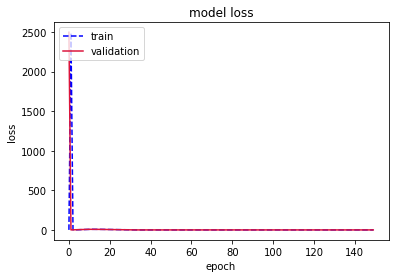

In [19]:
# Looking at loss rate over number of epochs

# Not sure which metrics are going to be the most important for us here?

plt.plot(history.history['loss'], '--', c='b')
plt.plot(history.history['val_loss'], c='crimson')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()